# This notebook is dedicated to EDA
***
Our main aim is to make use of the various indicators to predict the total sales of games worldwide

In [86]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
sb.set()

# data = pd.read_csv("cleaned_data.csv")

# importing main data
vg_sales = pd.read_csv("Final Data.csv")
vg_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61267 entries, 0 to 61266
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Rank          61267 non-null  int64  
 1   Name          61267 non-null  object 
 2   Platform      61267 non-null  object 
 3   Year          56554 non-null  float64
 4   Genre         61267 non-null  object 
 5   Publisher     61267 non-null  object 
 6   Developer     61267 non-null  object 
 7   Critic_Score  6551 non-null   float64
 8   User_Score    402 non-null    float64
 9   NA_Sales      13656 non-null  float64
 10  PAL_Sales     14020 non-null  float64
 11  JP_Sales      7672 non-null   float64
 12  Other_Sales   16365 non-null  float64
 13  Global_Sales  20302 non-null  float64
dtypes: float64(8), int64(1), object(5)
memory usage: 6.5+ MB


***
## Things to note from the initial dataset
***
* There are a lot of datapoints that have null values
* There are a total of `14` columns with `61267` rows
* There is `1` variable identified as `int64`
* There are `5` variables identified as `object`
* There are `8` variables identified as `float64`
* Rank is rather useless to us as this is merely used as an index



Since there are a lot of datapoints that have null values and we feel that we don't have enough usable indicators, we have decided to merge the dataset with another dataset (metaCritic.csv)

The code for the merging of data is in "data_cleaning.ipynb", and the csv output is saved as "merged_dataSet.csv"

vg_critic score and vg_user_score has a lot of null values. vg_critic score has around 60% of Null Values . Therefore it could be possibel to use Missing forest to fill the null values. As for vg_user_score we have decided to drop the entire column as there are too many null values.

In [87]:
# filling out the missing values using missforest
# from missingpy import MissForest
# imputer = MissForest()
# x = data["vg_critic_score"]

After merging the datasets, we obtain "merged_merged_merged_merged_merged_dataSet.csv" and we will import this as <span style="font-family:Courier New">merged_data</span> for future use

In [88]:
# getting rid of the old dataset to save some memory
del(vg_sales)

# importing new data
merged_data = pd.read_csv("merged_dataSet.csv")

merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10996 entries, 0 to 10995
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Platform         10996 non-null  object 
 1   meta_score       10996 non-null  int64  
 2   meta_UserReview  10996 non-null  object 
 3   Year             10412 non-null  float64
 4   Genre            10996 non-null  object 
 5   Publisher        10996 non-null  object 
 6   Developer        10996 non-null  object 
 7   vg_critic_score  3417 non-null   float64
 8   vg_user_score    261 non-null    float64
 9   NA_Sales         6144 non-null   float64
 10  PAL_Sales        6455 non-null   float64
 11  JP_Sales         2334 non-null   float64
 12  Other_Sales      6930 non-null   float64
 13  Global_Sales     7156 non-null   float64
dtypes: float64(8), int64(1), object(5)
memory usage: 1.2+ MB


In [89]:
merged_data.head()

,Platform,meta_score,meta_UserReview,Year,Genre,Publisher,Developer,vg_critic_score,vg_user_score,NA_Sales,PAL_Sales,JP_Sales,Other_Sales,Global_Sales
0,N64,99,9.1,1998.0,Adventure,Nintendo,Nintendo EAD,9.9,10.0,4.10,1.89,1.45,0.16,7.60
1,PS,98,7.4,2000.0,Sports,Activision,Neversoft Entertainment,9.3,NaN,3.05,1.41,0.02,0.20,4.68
2,PS3,98,7.7,2008.0,Action,Rockstar Games,Rockstar North,10.0,9.0,4.79,3.73,0.44,1.62,10.57
3,DC,98,8.4,1999.0,Fighting,Namco,Namco,9.6,NaN,NaN,NaN,0.34,0.00,0.34
4,X360,98,7.9,2008.0,Action,Rockstar Games,Rockstar North,10.0,NaN,6.80,3.11,0.14,1.04,11.09


***
## Things to note from the merged dataset
***
* meta_score, meta_userReview and an index (the first column) have been added
* Duplicated datapoints have been removed as a result of the merging
* meta_userReview is identified as an object but it contains float values
* Some columns from the original dataset have been renamed to avoid confusion 
* There are still some null values that we have to deal with
* We assume the NA vales in the sales categories to mean that there were no sales in those regions
* We are predicting the total sales of the games, but there is no data for total sales

In [90]:
# converting meta_userReview to float value

merged_data.loc[(merged_data['meta_UserReview'] == 'tbd')] = None
merged_data['meta_UserReview'] = merged_data['meta_UserReview'].astype(float)

In [91]:
# removing the rows with NULL values for year
merged_data.dropna(subset=['Year'], inplace=True)

# converting Year to an int64 type
merged_data['Year'] = merged_data['Year'].astype(int)

# making sure everything worked
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9940 entries, 0 to 10995
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Platform         9940 non-null   object 
 1   meta_score       9940 non-null   float64
 2   meta_UserReview  9940 non-null   float64
 3   Year             9940 non-null   int32  
 4   Genre            9940 non-null   object 
 5   Publisher        9940 non-null   object 
 6   Developer        9940 non-null   object 
 7   vg_critic_score  3335 non-null   float64
 8   vg_user_score    258 non-null    float64
 9   NA_Sales         5787 non-null   float64
 10  PAL_Sales        6130 non-null   float64
 11  JP_Sales         2313 non-null   float64
 12  Other_Sales      6568 non-null   float64
 13  Global_Sales     6789 non-null   float64
dtypes: float64(9), int32(1), object(4)
memory usage: 1.1+ MB


Since we assume that NULL values in the sales categories means that there were no sales in those regions, we shall replace those NULL values with 0

In [92]:
# replacing NULL values with 0
merged_data["NA_Sales"].fillna(0,inplace=True)
merged_data["PAL_Sales"].fillna(0,inplace=True)
merged_data["JP_Sales"].fillna(0,inplace=True)
merged_data["Other_Sales"].fillna(0,inplace=True)
merged_data["Global_Sales"].fillna(0,inplace=True)

# making sure everything worked
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9940 entries, 0 to 10995
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Platform         9940 non-null   object 
 1   meta_score       9940 non-null   float64
 2   meta_UserReview  9940 non-null   float64
 3   Year             9940 non-null   int32  
 4   Genre            9940 non-null   object 
 5   Publisher        9940 non-null   object 
 6   Developer        9940 non-null   object 
 7   vg_critic_score  3335 non-null   float64
 8   vg_user_score    258 non-null    float64
 9   NA_Sales         9940 non-null   float64
 10  PAL_Sales        9940 non-null   float64
 11  JP_Sales         9940 non-null   float64
 12  Other_Sales      9940 non-null   float64
 13  Global_Sales     9940 non-null   float64
dtypes: float64(9), int32(1), object(4)
memory usage: 1.1+ MB


Since we are predicting total sales and there is no column for that, we will add one column for total sales by summing all sales

In [93]:
# summing sales values and creating a new column
merged_data["Total_Sales"]= merged_data["NA_Sales"] + merged_data["PAL_Sales"] + merged_data["JP_Sales"] + merged_data["Other_Sales"] + merged_data["Global_Sales"]

# making sure everything worked
merged_data.info()

# exporting to csv
merged_data.to_csv("cleaned_data.csv")

# clearing up memory
del(merged_data)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9940 entries, 0 to 10995
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Platform         9940 non-null   object 
 1   meta_score       9940 non-null   float64
 2   meta_UserReview  9940 non-null   float64
 3   Year             9940 non-null   int32  
 4   Genre            9940 non-null   object 
 5   Publisher        9940 non-null   object 
 6   Developer        9940 non-null   object 
 7   vg_critic_score  3335 non-null   float64
 8   vg_user_score    258 non-null    float64
 9   NA_Sales         9940 non-null   float64
 10  PAL_Sales        9940 non-null   float64
 11  JP_Sales         9940 non-null   float64
 12  Other_Sales      9940 non-null   float64
 13  Global_Sales     9940 non-null   float64
 14  Total_Sales      9940 non-null   float64
dtypes: float64(10), int32(1), object(4)
memory usage: 1.2+ MB


We have thus come to the end of the main data merging and cleaning section of EDA :)

***
## Start of comparisons
***

In [94]:
data = pd.read_csv("cleaned_data.csv")

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9940 entries, 0 to 9939
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       9940 non-null   int64  
 1   Platform         9940 non-null   object 
 2   meta_score       9940 non-null   float64
 3   meta_UserReview  9940 non-null   float64
 4   Year             9940 non-null   int64  
 5   Genre            9940 non-null   object 
 6   Publisher        9940 non-null   object 
 7   Developer        9940 non-null   object 
 8   vg_critic_score  3335 non-null   float64
 9   vg_user_score    258 non-null    float64
 10  NA_Sales         9940 non-null   float64
 11  PAL_Sales        9940 non-null   float64
 12  JP_Sales         9940 non-null   float64
 13  Other_Sales      9940 non-null   float64
 14  Global_Sales     9940 non-null   float64
 15  Total_Sales      9940 non-null   float64
dtypes: float64(10), int64(2), object(4)
memory usage: 1.2+ MB


In [95]:
data.head()

,Unnamed: 0,Platform,meta_score,meta_UserReview,Year,Genre,Publisher,Developer,vg_critic_score,vg_user_score,NA_Sales,PAL_Sales,JP_Sales,Other_Sales,Global_Sales,Total_Sales
0,0,N64,99.0,9.1,1998,Adventure,Nintendo,Nintendo EAD,9.9,10.0,4.10,1.89,1.45,0.16,7.60,15.20
1,1,PS,98.0,7.4,2000,Sports,Activision,Neversoft Entertainment,9.3,NaN,3.05,1.41,0.02,0.20,4.68,9.36
2,2,PS3,98.0,7.7,2008,Action,Rockstar Games,Rockstar North,10.0,9.0,4.79,3.73,0.44,1.62,10.57,21.15
3,3,DC,98.0,8.4,1999,Fighting,Namco,Namco,9.6,NaN,0.00,0.00,0.34,0.00,0.34,0.68
4,4,X360,98.0,7.9,2008,Action,Rockstar Games,Rockstar North,10.0,NaN,6.80,3.11,0.14,1.04,11.09,22.18


***
### How is the distribution of data?
***

In [96]:
# Numeric Predictors
data[["meta_score", "meta_UserReview", "Year", "vg_critic_score", "vg_user_score", "NA_Sales", "PAL_Sales", "JP_Sales", "Other_Sales", "Global_Sales"]].describe()

,meta_score,meta_UserReview,Year,vg_critic_score,vg_user_score,NA_Sales,PAL_Sales,JP_Sales,Other_Sales,Global_Sales
count,9940.000000,9940.000000,9940.000000,3335.000000,258.000000,9940.000000,9940.000000,9940.000000,9940.000000,9940.000000
mean,73.455131,7.185543,2010.089135,7.614213,8.457752,0.270714,0.173138,0.048550,0.058742,0.551224
std,11.024249,1.282943,6.234291,1.166353,1.214102,0.847875,0.620718,0.250213,0.232481,1.736267
min,20.000000,0.200000,1970.000000,1.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,67.000000,6.600000,2005.000000,7.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,75.000000,7.500000,2010.000000,7.800000,8.800000,0.040000,0.010000,0.000000,0.010000,0.090000
75%,81.000000,8.100000,2016.000000,8.400000,9.300000,0.230000,0.120000,0.000000,0.040000,0.480000
max,99.000000,9.700000,2021.000000,10.000000,10.000000,41.360000,29.020000,6.500000,10.570000,82.650000


From the above, we can see:
* vg_user_score is not a good indicator as there are too few rows when compared to the rest of the data. Thus, we will be ignoring it.
* Sales values are all stored in Millions. Do we need to change it later?
* Most games (75%) were released after 2005 and the first game was released in 1970. This means that there were more games released from 2005 to 2022 (17 years) than from 1970 to 2005 (35 years)
    * While this may not be useful for our project, it is interesting to note the effects of technological advancement on games


In [97]:
# categorical predictors
data[["Genre","Publisher"]].describe()

,Genre,Publisher
count,9940,9940
unique,20,864
top,Action,Electronic Arts
freq,1580,531


From the above, we can see:
* Publisher is not a good indicator as there are too many publishers 
* Genre could potentially be a good indicator, but we don't know too much about it yet

***
### Visualisations
***

#### Distribution of numeric indicators

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9940 entries, 0 to 9939
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   meta_score       9940 non-null   float64
 1   meta_UserReview  9940 non-null   float64
 2   Year             9940 non-null   int64  
 3   vg_critic_score  3335 non-null   float64
 4   vg_user_score    258 non-null    float64
 5   NA_Sales         9940 non-null   float64
 6   PAL_Sales        9940 non-null   float64
 7   JP_Sales         9940 non-null   float64
 8   Other_Sales      9940 non-null   float64
 9   Global_Sales     9940 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 776.7 KB


AttributeError: 'numpy.ndarray' object has no attribute 'boxplot'

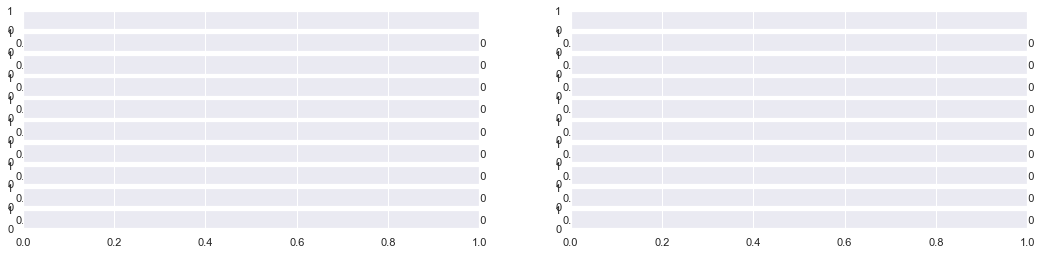

In [104]:
# distribution of meta_score
f, axes = plt.subplots(10, 2, figsize=(18, 4))
tempdata = data[["meta_score", "meta_UserReview", "Year", "vg_critic_score", "vg_user_score", "NA_Sales", "PAL_Sales", "JP_Sales", "Other_Sales", "Global_Sales"]]
tempdata.info()
for each in tempdata:
    p = sb.boxplot(data = data['meta_score'], orient = "h", ax = axes[0])
    p = sb.histplot(data = data['meta_score'], ax = axes[1])

We can see that the ratings are mostly gathered between 67 and 81 (quartiles). There are also multiple "peaks" in the numbers. Why is this so?

What is the correlation between meta_score and total sales?

### Comparing Genre vs Total Sales

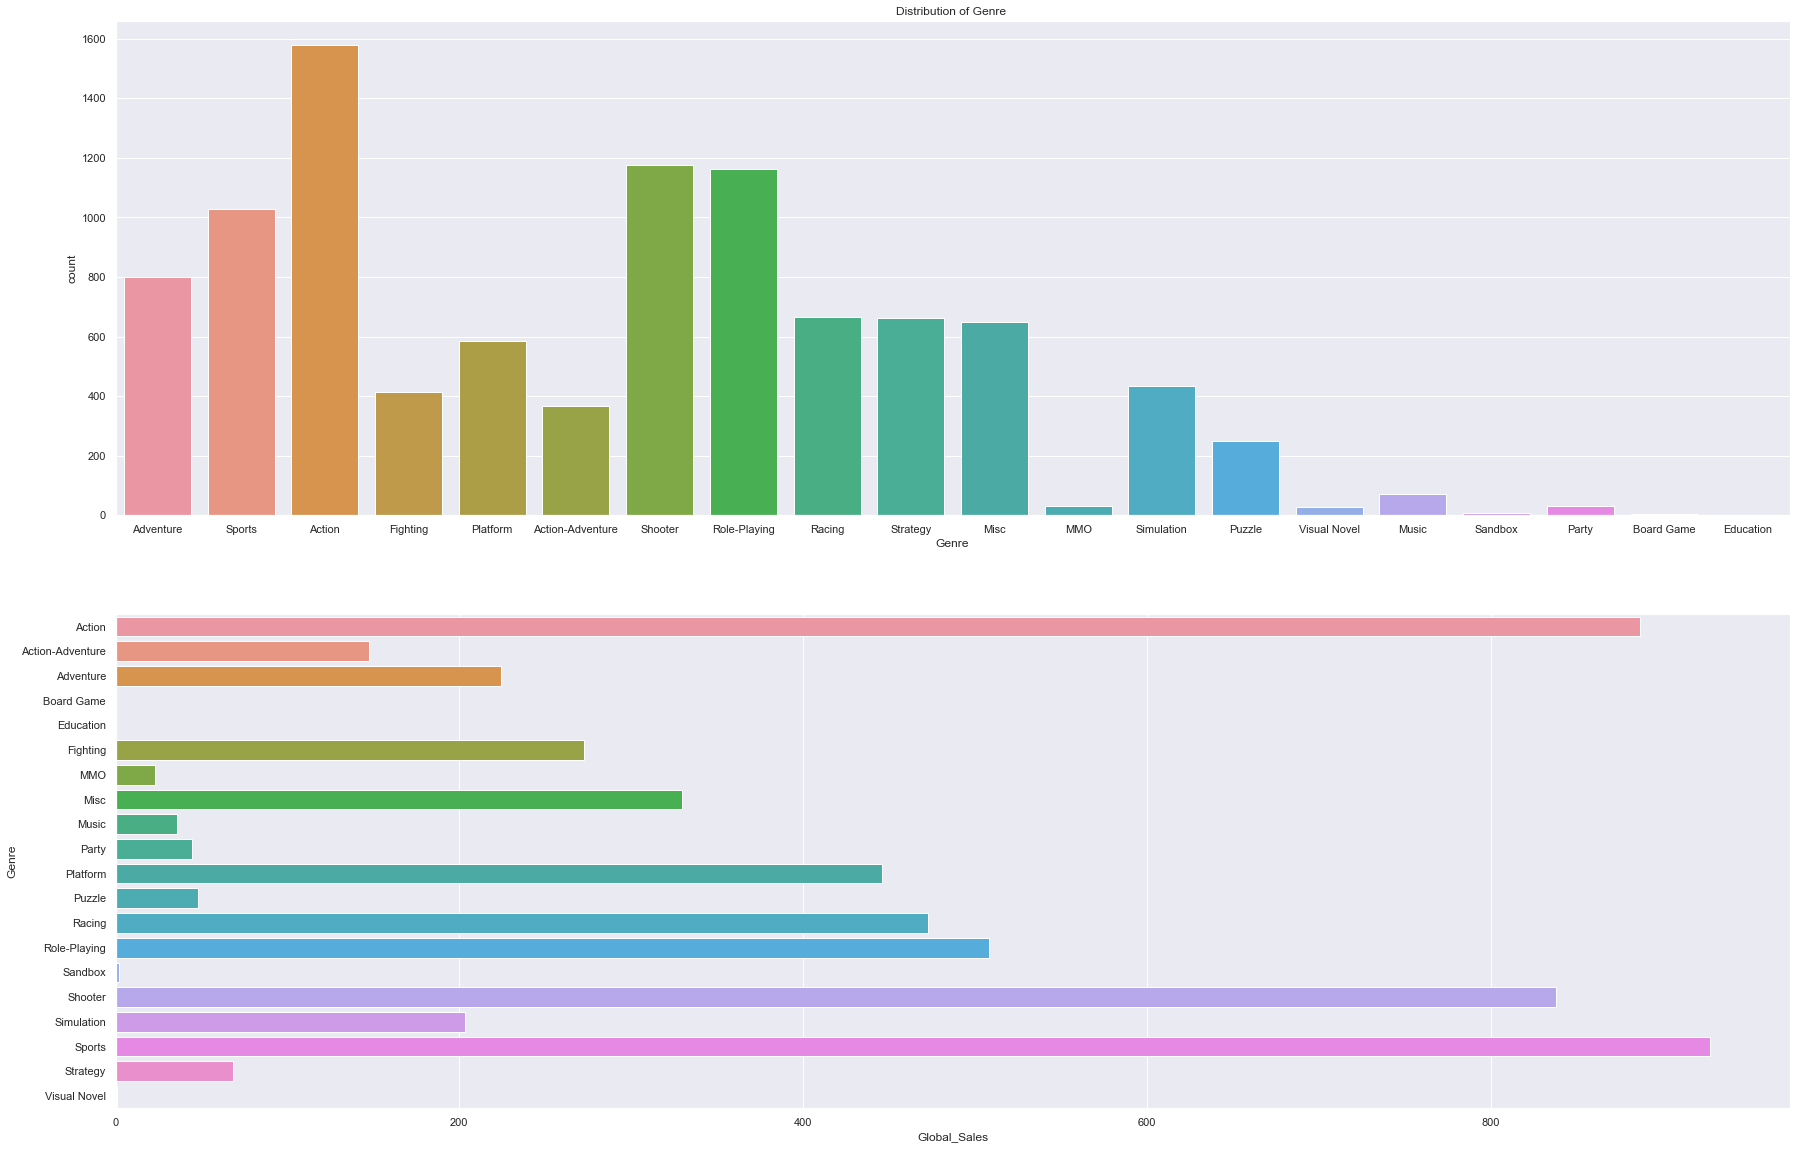

In [98]:
# genre vs global sales
f,axes = plt.subplots(2,1,figsize=(30,20))
axes[0].set_title("Distribution of Genre ")
sb.countplot(x="Genre", data = data , ax = axes[0])

genereSale = data.groupby('Genre')['Global_Sales'].sum()
p = sb.barplot(y=genereSale.index, x=genereSale,ax=axes[1])

what do we understand from this?

### Platform vs global sales

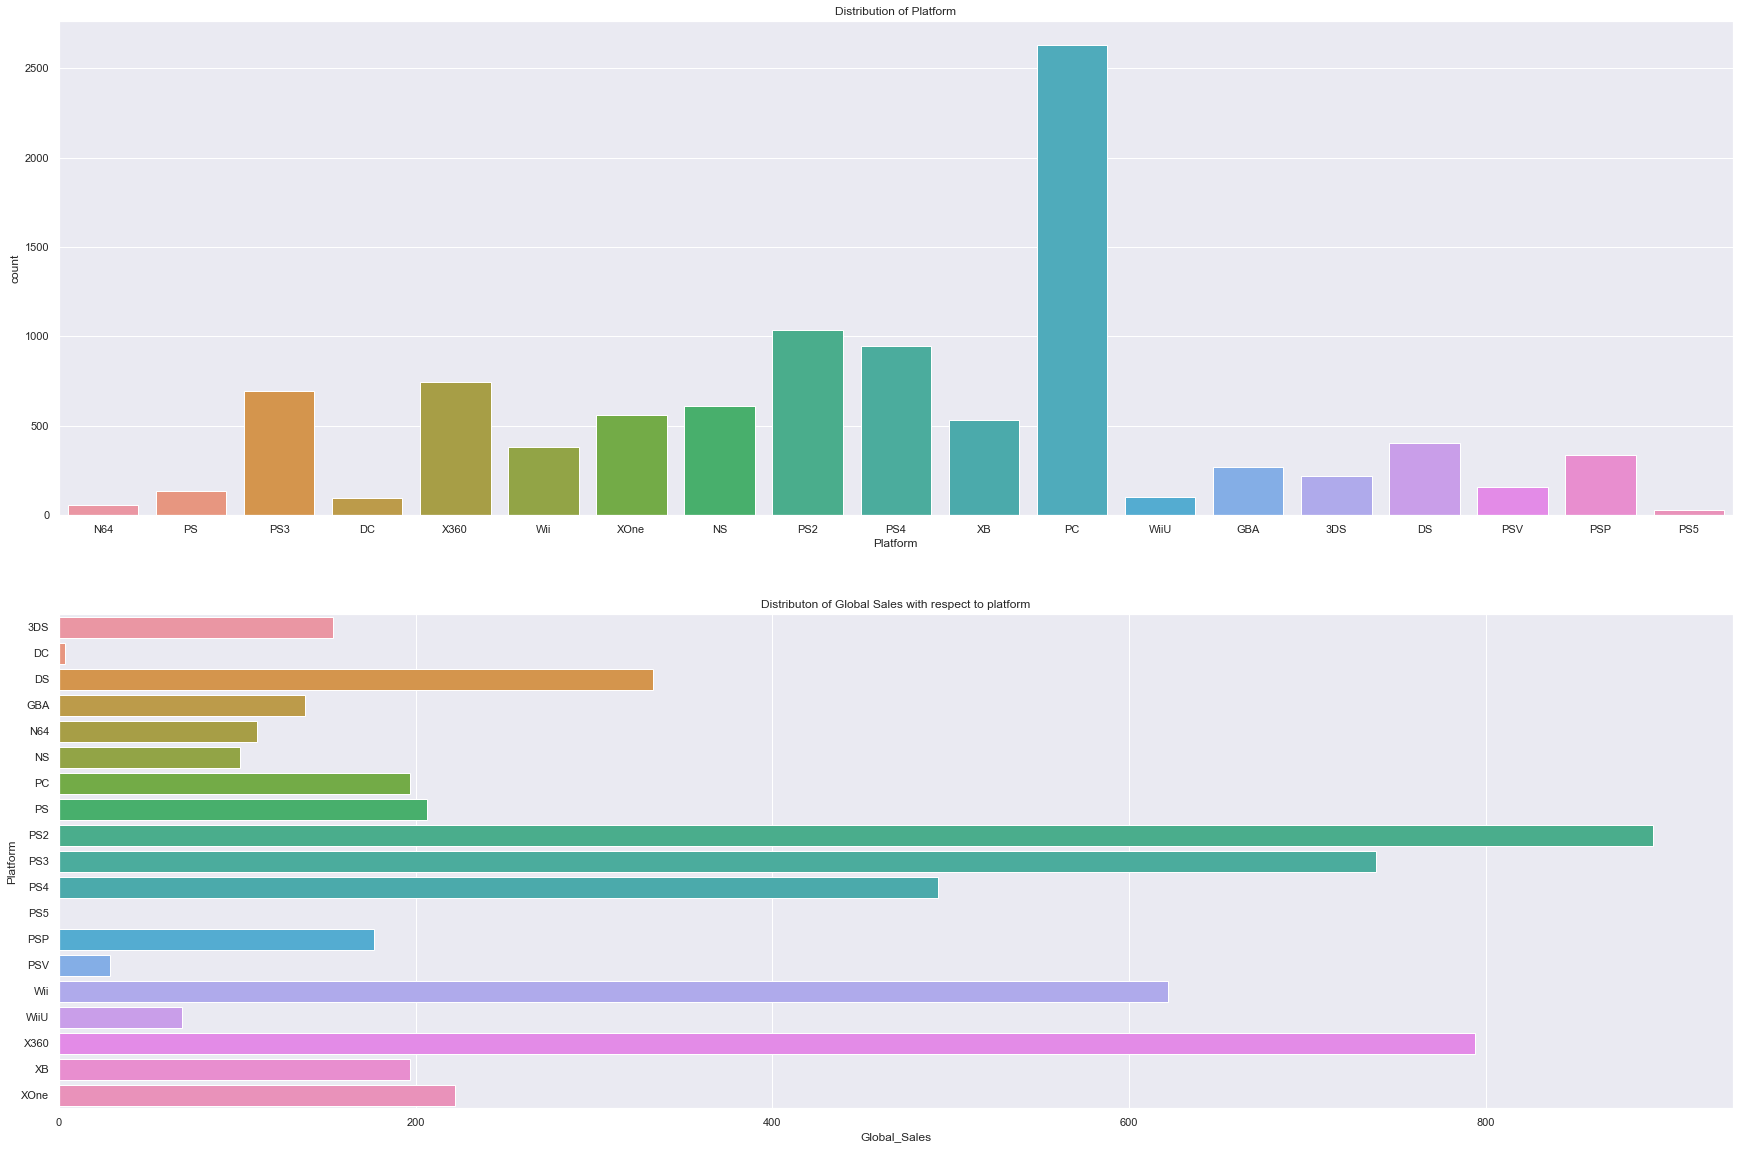

In [75]:
# platform vs global sales
f,axes = plt.subplots(2,1,figsize=(30,20))
axes[0].set_title("Distribution of Platform")
sb.countplot(x="Platform", data = data , ax = axes[0])

platformSale = data.groupby('Platform')['Global_Sales'].sum()
axes[1].set_title("Distributon of Global Sales with respect to platform")
p = sb.barplot(y=platformSale.index, x=platformSale,ax=axes[1])

what do we understand from this?

## 2. things to compare:
1. genre vs global sales
2. platform vs global sales (we will remove the platforms that are small, so that we can focus on the bigger picture)
3. correlation between regional sales vs platform (is there a region that likes a particular platform?)
4. correlation between regional sales vs genre (is there a region that likes a particular genre?)
5. correlation between regional sales vs global sales

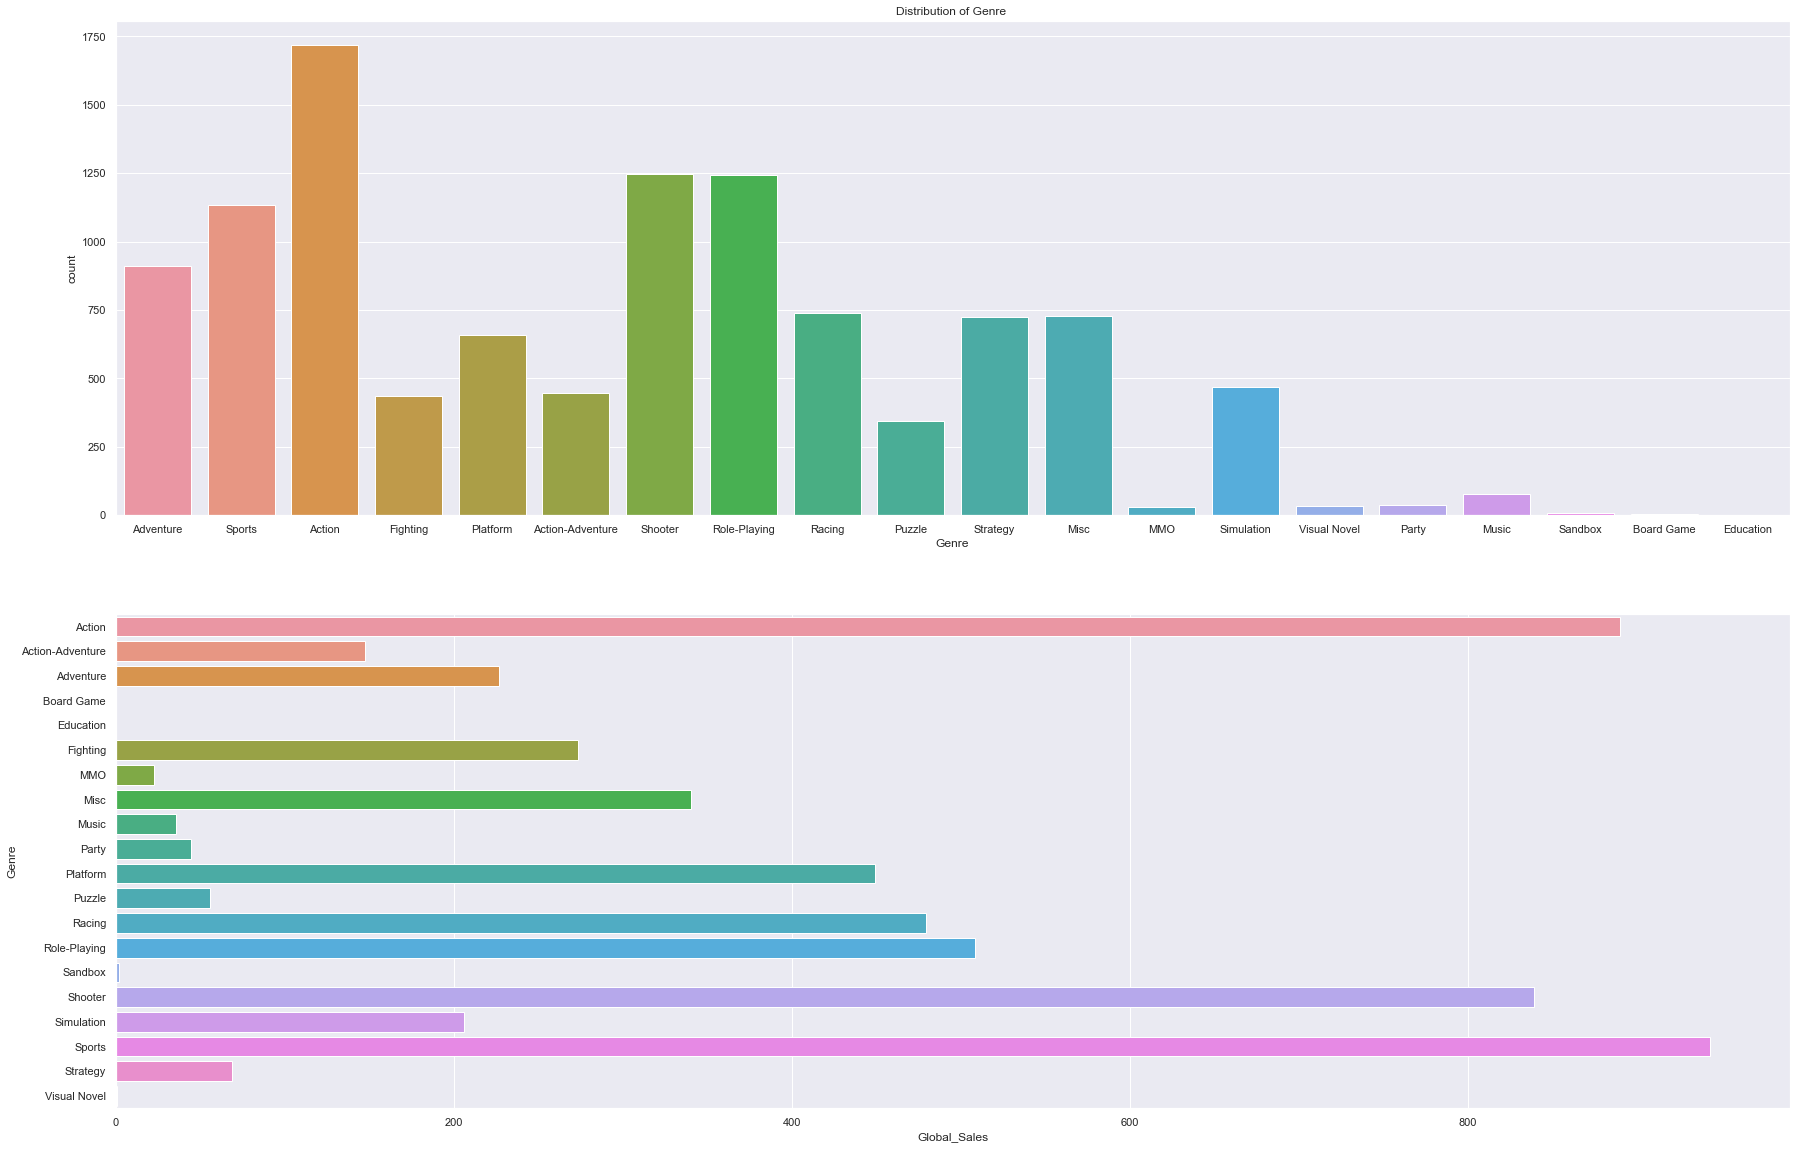

In [13]:
# genre vs global sales
f,axes = plt.subplots(2,1,figsize=(30,20))
axes[0].set_title("Distribution of Genre ")
sb.countplot(x="Genre", data = merged_data , ax = axes[0])

genereSale = merged_data.groupby('Genre')['Global_Sales'].sum()
p = sb.barplot(y=genereSale.index, x=genereSale,ax=axes[1])

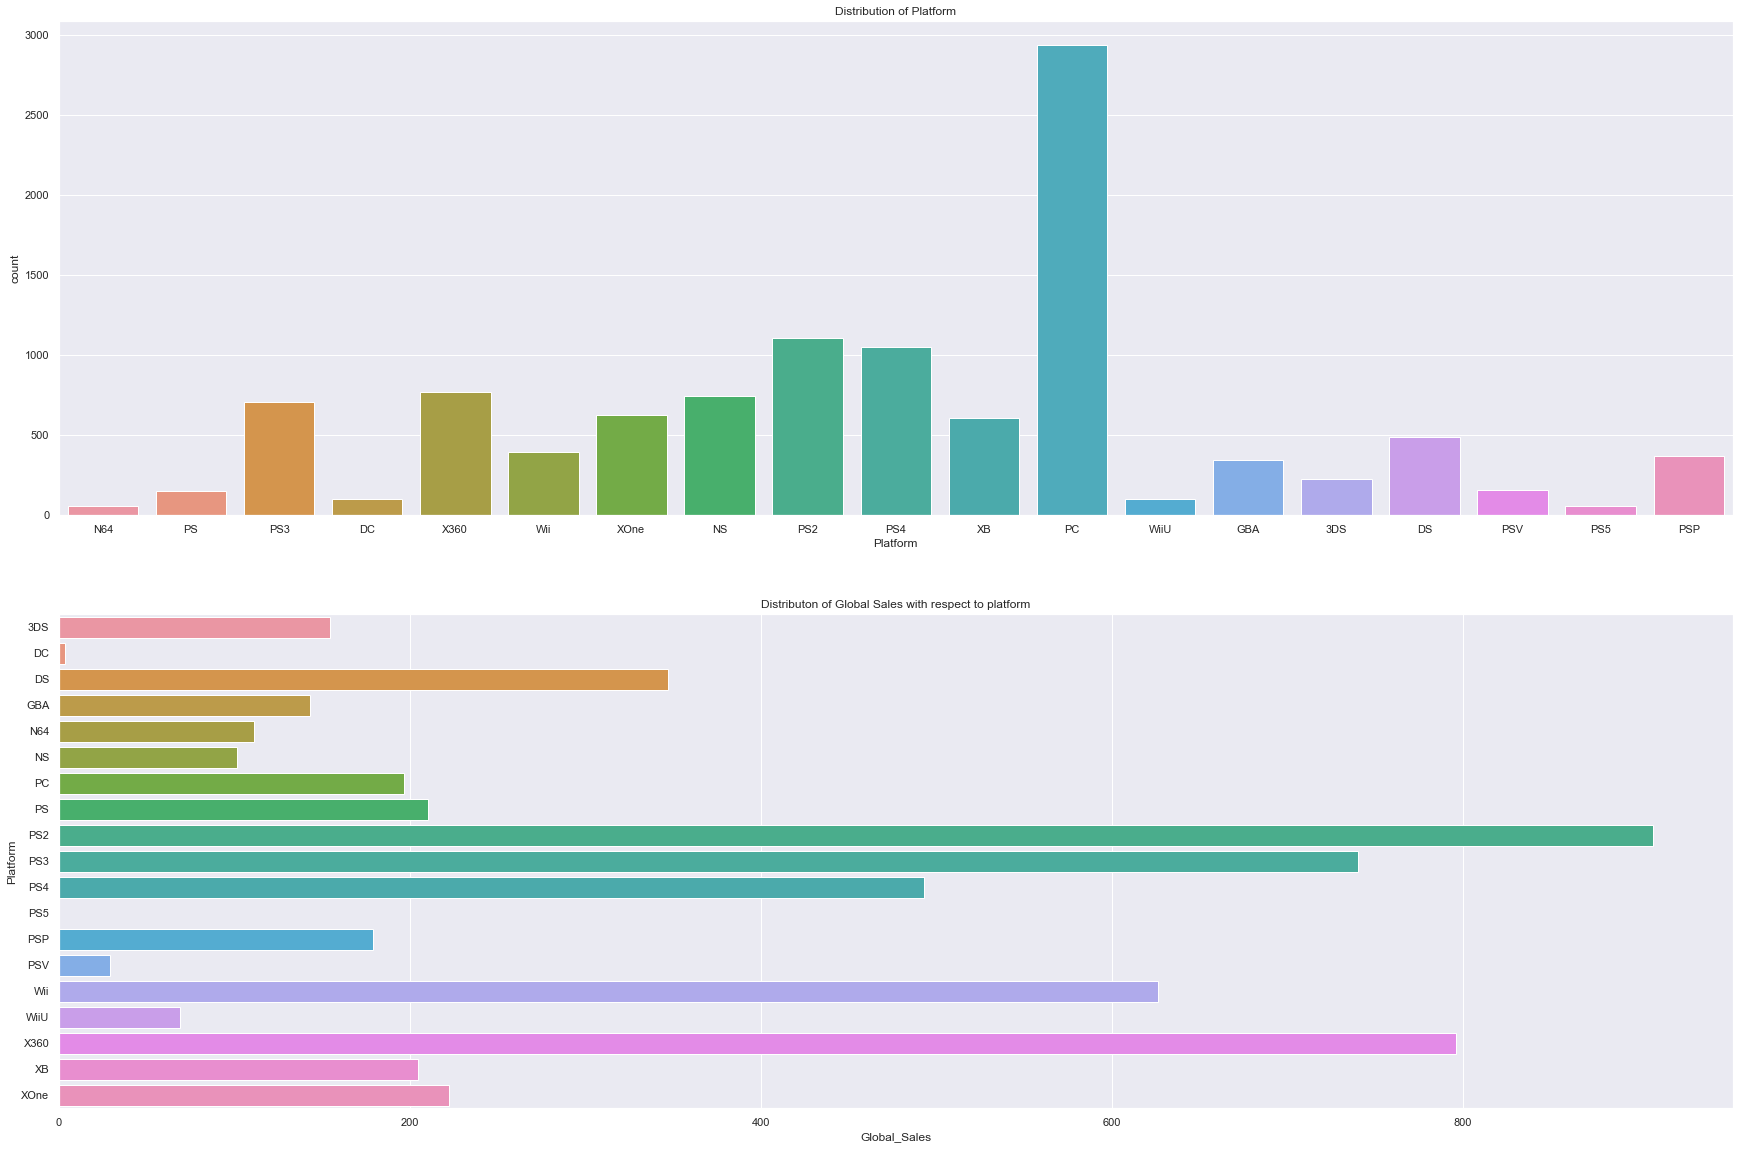

In [14]:
# platform vs global sales
f,axes = plt.subplots(2,1,figsize=(30,20))
axes[0].set_title("Distribution of Platform")
sb.countplot(x="Platform", data = merged_data , ax = axes[0])

platformSale = merged_data.groupby('Platform')['Global_Sales'].sum()
axes[1].set_title("Distributon of Global Sales with respect to platform")
p = sb.barplot(y=platformSale.index, x=platformSale,ax=axes[1])

In [15]:
#correlation between regional sales and platform

In [16]:
#Identifying top games per year based on the different predictors

top_game = merged_data.groupby('Year')['Global_Sales']
top_game.head()


0         7.60
1         4.68
2        10.57
3         0.34
4        11.09
         ...  
5402       NaN
7298       NaN
9031      0.03
10335      NaN
10584      NaN
Name: Global_Sales, Length: 147, dtype: float64

## 3. main issues
1. we realised that we don't have a lot of indicators to work with, so we merged another dataset and cleaned it (can add in the cleaning code here a bit ah). this gives us more indicators to work with.

## 4. more things to compare:
1. correlation between meta score and all sales (regional + global) -> is meta score a good indicator of sales in general?
2. correlation between user review and all sales (regional + global) -> is user review a good indicator of sales in general?

## 5. end of EDA
- we decide on what indicators we are using, based on the results that we get from the EDA

In [17]:
ml = merged_data
ml.drop("Genre",axis =1,inplace = True)
ml.drop("vg_user_score",axis =1,inplace = True)
ml.head()
ml.to_csv('ml_dataSet.csv')

